# Example: Half Adder
In this example we write a quantum algorithm to perform an add operation between two qubits and store the result in two qubits that act as output register.

The truth table of the circuit is
| in q1 | in q2 | out q4 | out q3 | out  (integer) |
|-------|-------|--------|--------|----------------|
| 0     | 0     | 0      | 0      | 0              |
| 0     | 1     | 0      | 1      | 1              |
| 1     | 0     | 0      | 1      | 1              |
| 1     | 1     | 1      | 0      | 2              |

The circuit that we will code to implement a half adder (with an additional unimportant phase) is as follows

![half adder](half_adder.png)

The two `X` operations at the beginning are used to generate the input, in this case both input qubits are set to `1`.

In [1]:
# A small helper routine for nice output
def get_binary(x: int, size: int) -> str:
    """Return a string representation of int x with size positions."""
    return format(x, 'b').zfill(size)

We import required classes and modules from qoqo. Circuit is the main class to represent quantum circuits. The operations module contains one- and two-qubit operations such as Hadamard or CNOT.

In [2]:
from qoqo import Circuit
from qoqo import operations as ops
from pprint import pprint as pp
import math

We define a method to generate the main block of the half-adder circuit.

In [3]:
def half_adder_main() -> Circuit():
    half_adder = Circuit(4)
    ####################
    # Least relevant bit
    half_adder += ops.CNOT(control=0, target=2)
    half_adder += ops.CNOT(control=1, target=2)
    ###################
    # Most relevant bit
    # Controlled H
    half_adder += ops.RotateY(3, math.pi / 4)
    half_adder += ops.CNOT(0, 3)
    half_adder += ops.RotateY(3, -math.pi / 4)
    # Controlled Z
    half_adder += ops.Hadamard(3)
    half_adder += ops.CNOT(1, 3)
    half_adder += ops.Hadamard(3)
    # Controlled H
    half_adder += ops.RotateY(3, math.pi / 4)
    half_adder += ops.CNOT(0, 3)
    half_adder += ops.RotateY(3, -math.pi / 4)
    return half_adder

Let's add everything together. We add a complex classical register to store the state vector of the qubits after our calculation. Other types of registers available in qoqo are `DefinitionBit` for bit registers used to store actual measurement results of a quantum computer and `DefinitionFloat` to store real valued results.

We use the `GetStateVector` pragma operation. A Pragma operation is information for the compiler / qoqo only and will not be sent to the actual quantum computer. We will encounter other important Pragmas later on. The `GetStateVector` pragma operation obtains the state vector of the qubits and stores it in the defined output register ('ro'). It accepts an additional measurement circuit that would be added to the circuit before measuring. The state vector can only be obtained in simulations on conventional computers, never from the real device.

In [4]:
half_adder = Circuit(4)
half_adder += ops.DefinitionComplex('ro', 2**4, is_output=True)
# Init
half_adder += ops.PauliX(0)
half_adder += ops.PauliX(1)
#main
half_adder += half_adder_main()
# Measure
half_adder += ops.PragmaGetStateVector('ro', Circuit())

In [5]:
print(half_adder)
# from qoqo_qasm import qasm_call_circuit
# qasm_call_circuit(half_adder_main())

DefinitionComplex(DefinitionComplex { name: "ro", length: 16, is_output: true })
PauliX(PauliX { qubit: 0 })
PauliX(PauliX { qubit: 1 })
CNOT(CNOT { control: 0, target: 2 })
CNOT(CNOT { control: 1, target: 2 })
RotateY(RotateY { qubit: 3, theta: Float(0.7853981633974483) })
CNOT(CNOT { control: 0, target: 3 })
RotateY(RotateY { qubit: 3, theta: Float(-0.7853981633974483) })
Hadamard(Hadamard { qubit: 3 })
CNOT(CNOT { control: 1, target: 3 })
Hadamard(Hadamard { qubit: 3 })
RotateY(RotateY { qubit: 3, theta: Float(0.7853981633974483) })
CNOT(CNOT { control: 0, target: 3 })
RotateY(RotateY { qubit: 3, theta: Float(-0.7853981633974483) })
PragmaGetStateVector(PragmaGetStateVector { readout: "ro", circuit: Some(Circuit { definitions: [], operations: [], _roqoqo_version: RoqoqoVersion }) })



We simulate the half adder using `qoqo_quest`. Running the circuit in the backend returns a tuple with entries for all registers of the three different types.

We print the complex coefficients (amplitudes) of the quantum state. The input qubits are the two bits on the right side (as they are qubits 0 and 1) while the output is stored in the most relevant bits (the two right bits). As expected, the state `|1011>` is populated while all other states are empty.

In [6]:
from qoqo_quest import Backend
backend = Backend(4)
(
    res_bit_registers,
    res_float_registers,
    res_complex_registers
) = backend.run_circuit(half_adder)
pp({
    get_binary(x, 4): value.real for x, value in enumerate(
        res_complex_registers['ro'][0]
    )
})

{'0000': 0.0,
 '0001': 0.0,
 '0010': 0.0,
 '0011': 1.6653345369377348e-16,
 '0100': 0.0,
 '0101': 0.0,
 '0110': 0.0,
 '0111': 0.0,
 '1000': 0.0,
 '1001': 0.0,
 '1010': 0.0,
 '1011': 0.9999999999999997,
 '1100': 0.0,
 '1101': 0.0,
 '1110': 0.0,
 '1111': 0.0}


## Simulating an experiment

How would the result that we would get from a real quantum computer look? Let's try it out!

We define a number of measurements, i.e., repetitions and measurements of the circuit and add a bit register to store the measured values for each run.

We add `MeasureQubit` operations for the two output qubits.
To make this more interesting we initialize the input qubits in a superposition of all possible states using Hadamard gates `H`.

In [7]:
number_measurements = 1000
half_adder = Circuit(4)
half_adder += ops.DefinitionBit('ro', 2, is_output=True)
# Input
half_adder += ops.Hadamard(0)
half_adder += ops.Hadamard(1)
# Main
half_adder += half_adder_main()
# Measure
half_adder += ops.MeasureQubit(2, 'ro', readout_index=0)
half_adder += ops.MeasureQubit(3, 'ro', readout_index=1)
half_adder += ops.PragmaSetNumberOfMeasurements(number_measurements, 'ro')


In [8]:
(
    res_bit_registers,
    res_float_registers,
    res_complex_registers
) = backend.run_circuit(half_adder)
# transform measured bitstring into integers
results = [int(f"{int(x[1])}{int(x[0])}", base=2) for x in res_bit_registers['ro']]
# pp(results)

We plot the histogram of the measured bitstring interpreted as integer. We expect 25% 0, 50% 1 and 25% 2.

(array([237., 521., 242.]),
 array([-0.5,  0.5,  1.5,  2.5]),
 <BarContainer object of 3 artists>)

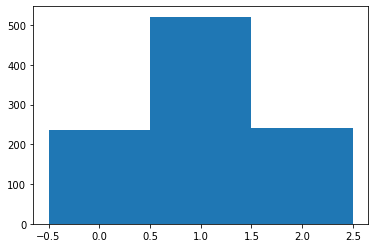

In [9]:
from matplotlib import pyplot as plt
plt.hist(results, bins=[-0.5, 0.5, 1.5, 2.5])